<a href="https://colab.research.google.com/github/Suhit97/Sunspots-detection-using-Conv-1D-and-LSTM/blob/master/Sunspots_Detections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-08-09 21:11:56--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.003s  

2020-08-09 21:11:57 (19.2 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



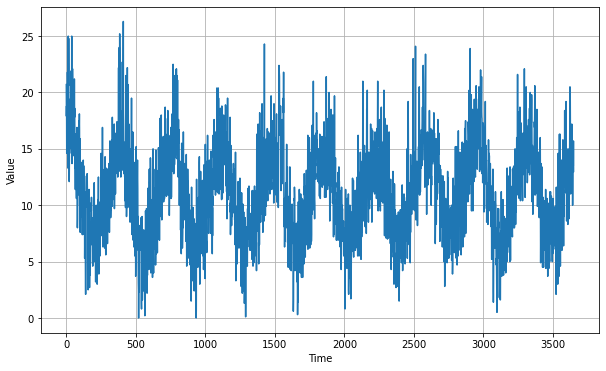

In [ ]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:


split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000




In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()

window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 28ms/step - loss: 70.9555 - mae: 71.4553
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 68.7780 - mae: 69.2778
Epoch 3/100
10/10 [==============================] - 0s 23ms/step - loss: 65.4832 - mae: 65.9830
Epoch 4/100
10/10 [==============================] - 0s 23ms/step - loss: 61.5386 - mae: 62.0383
Epoch 5/100
10/10 [==============================] - 0s 23ms/step - loss: 57.0989 - mae: 57.5984
Epoch 6/100
10/10 [==============================] - 0s 22ms/step - loss: 52.2012 - mae: 52.7006
Epoch 7/100
10/10 [==============================] - 0s 22ms/step - loss: 46.7943 - mae: 47.2935
Epoch 8/100
10/10 [==============================] - 0s 24ms/step - loss: 40.7921 - mae: 41.2911
Epoch 9/100
10/10 [==============================] - 0s 23ms/step - loss: 34.0812 - mae: 34.5802
Epoch 10/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

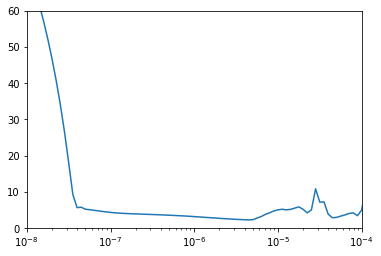

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 0s 15ms/step - loss: 9.9814 - mae: 10.4694
Epoch 2/150
25/25 [==============================] - 0s 15ms/step - loss: 2.5295 - mae: 2.9923
Epoch 3/150
25/25 [==============================] - 0s 15ms/step - loss: 1.9503 - mae: 2.4047
Epoch 4/150
25/25 [==============================] - 0s 13ms/step - loss: 1.8619 - mae: 2.3151
Epoch 5/150
25/25 [==============================] - 0s 13ms/step - loss: 1.8214 - mae: 2.2733
Epoch 6/150
25/25 [==============================] - 0s 14ms/step - loss: 1.7909 - mae: 2.2418
Epoch 7/150
25/25 [==============================] - 0s 13ms/step - loss: 1.7686 - mae: 2.2186
Epoch 8/150
25/25 [==============================] - 0s 13ms/step - loss: 1.7413 - mae: 2.1906
Epoch 9/150
25/25 [==============================] - 0s 13ms/step - loss: 1.7193 - mae: 2.1681
Epoch 10/150
25/25 [==============================] - 0s 12ms/step - loss: 1.7000 - mae: 2.1482
Epoch 11/150
25/25 [============================

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

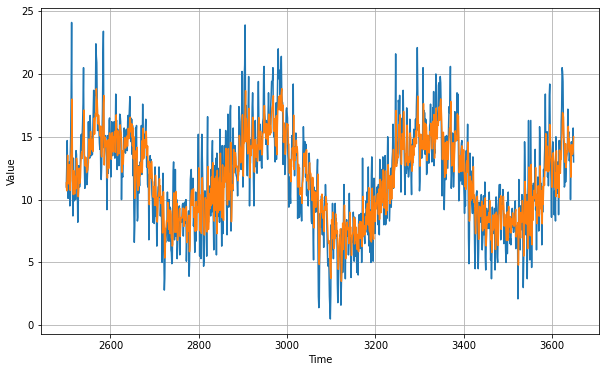

In [ ]:


plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:


tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()



1.779627

In [ ]:
print(rnn_forecast)

[11.329955  10.705945  12.12524   ... 13.6044445 13.796743  15.009318 ]
